In this notebook we build a simple auotencoder for Mnist data, and show how to use it for anomaly detection.

In [3]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

Both the encoder and the decoder are just composed by a couple of dense layers.
The latent dimension is 16. This means that each input is reduced from an initial dimensions of 28*28=784 to a an internal dimension of just 16 floats.

Most of the relevant information is preserved, as testified by the fact that we are able to reconstruct, out of this 16 values, an image very similar to the original one.

In [6]:
# size of our encoded representations
encoding_dim = 16 
mid_dim = 64

# input placeholder
input_img = layers.Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = layers.Dense(mid_dim, activation='relu')(input_img)
encoded = layers.Dense(encoding_dim, activation='relu')(encoded)
# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(mid_dim, activation='relu')(encoded)
decoded = layers.Dense(784, activation='sigmoid')(decoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

In [7]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_5 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                1088      
_________________________________________________________________
dense_7 (Dense)              (None, 784)               50960     
Total params: 103,328
Trainable params: 103,328
Non-trainable params: 0
_________________________________________________________________


We can now compile the model. 

As loss function we can take mse or categorical crossentropy, as you prefer. 

In [18]:
adam = Adam(lr=0.001)
autoencoder.compile(optimizer=adam, loss='mse')

We now load the datatet, and normalize it in the range [0,1]. We are not using labels.

In [19]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


Time to fit the model. Observe that the ground truth we need to compare with is in this case the input itself. In other words, the loss is the distance between the inout $X$ and its reconstruction $\hat{X}$

In [20]:
autoencoder.fit(x_train, x_train,
                epochs=20,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/20
235/235 [==============================] - 1s 4ms/step - loss: 0.0165 - val_loss: 0.0160
Epoch 2/20
235/235 [==============================] - 1s 3ms/step - loss: 0.0163 - val_loss: 0.0159
Epoch 3/20
235/235 [==============================] - 1s 3ms/step - loss: 0.0162 - val_loss: 0.0158
Epoch 4/20
235/235 [==============================] - 1s 3ms/step - loss: 0.0161 - val_loss: 0.0157
Epoch 5/20
235/235 [==============================] - 1s 3ms/step - loss: 0.0160 - val_loss: 0.0157
Epoch 6/20
235/235 [==============================] - 1s 3ms/step - loss: 0.0159 - val_loss: 0.0156
Epoch 7/20
235/235 [==============================] - 1s 3ms/step - loss: 0.0159 - val_loss: 0.0156
Epoch 8/20
235/235 [==============================] - 1s 4ms/step - loss: 0.0158 - val_loss: 0.0154
Epoch 9/20
235/235 [==============================] - 1s 3ms/step - loss: 0.0158 - val_loss: 0.0154
Epoch 10/20
235/235 [==============================] - 1s 3ms/step - loss: 0.0157 - val_loss: 0.0153

Let us check the result.

First of all we conpute all reconstructions for images in the test set.

In [11]:
decoded_imgs = autoencoder.predict(x_test)

Now we can plot the result. We pick ten random images, and for each of them we show the original and the reconstruction obtained from the autoencoder.

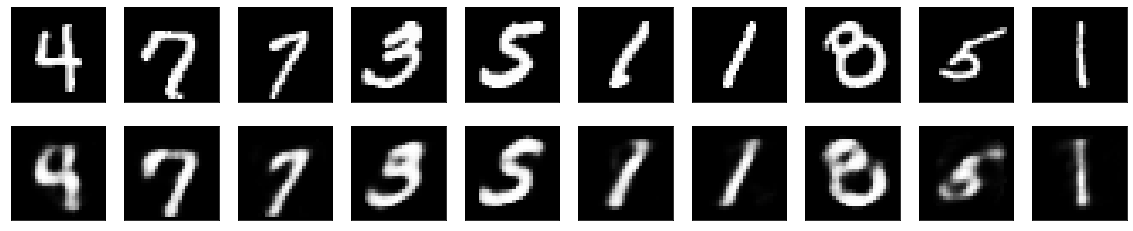

In [21]:
import matplotlib.pyplot as plt

n = 10 #no images to plot
imgs = np.random.randint(low=0,high=10000,size=n)
plt.figure(figsize=(20, 4))
for (i,idx) in enumerate(imgs):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


# Anomaly detection

We want now to show how we can use an autoencoder for anomaly detection.

The genral idea is that the encoding learned by the autoenoder is data-specific. This means that if we apply the autoencoder to an outlier, the resulting reconstruction should be sensibily worse than usual, and we may exploit this simple fact to detect the anomaly.

The first step of the procedure is to identify the canonical expected reconstruction error on true data, and the associated standard deviation.

In [30]:
mse_all = np.mean(np.square(decoded_imgs - x_test),axis=1) #mean error for each input
print(mse.shape) 
mse = np.mean(mse_all)
std = np.std(mse_all)
print("mse is {}, with a standard deviation of {}".format(mse,std))

()
mse is 0.01905367523431778, with a standard deviation of 0.009669928811490536


Now we create an "anomaly". We simply take a normal image from the dataset, and rotate it of 90 degrees. 

For this example, we use image no 15 in the test set.

1/1 [==============================] - 0s 16ms/step - loss: 0.0270
0.027014590799808502


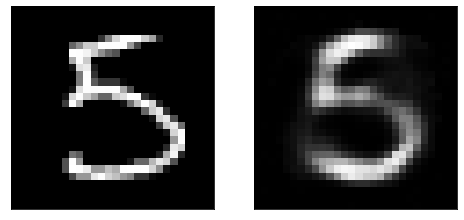

In [31]:
test = x_test[15].reshape(1,784)
print(autoencoder.evaluate(test,test))

plt.figure(figsize=(8,4))
ax = plt.subplot(1,2,1)
plt.imshow(x_test[15].reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax = plt.subplot(1, 2, 2)
plt.imshow(decoded_imgs[15].reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.savefig('lyar1.jpg')
plt.show()

Observe that the reconstruction is not particularly good, but still the loss (0.207) is more or less on std away from the mean, that is a normal behaviour.

Now, let us rotate it and repeat the computation.

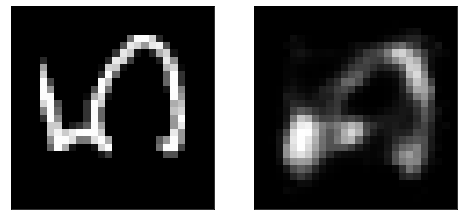

In [33]:
rotated = np.rot90(x_test[15].reshape(28,28))
predicted = autoencoder.predict(rotated.reshape(1,784))[0].reshape(28,28)

plt.figure(figsize=(8,4))
ax = plt.subplot(1,2,1)
plt.imshow(rotated)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax = plt.subplot(1, 2, 2)
plt.imshow(predicted)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.savefig('lyar2.jpg')
plt.show()

In [35]:
mse = np.mean(np.square(predicted-rotated))
print("mse is {}".format(mse))

mse is 0.052468638867139816


The mse in this case is 0.052, more than 3 std away form the mean, that is surely an anomaly!!

Let us finally observe that, instead of using mean and variance of reconstruction errors, we could have directly worked in the latent space.

In fact, autoencoders generalize Principal Component Ananlysis, extracting relevant, non linear combinations of the input features. Any anomaly will 
sensibibly discost from canonical values of the latent encoding.